# Head to head modelling 

Main idea here is to get season stats for each team, then take simple game results and make that dataset be team1_record, team1_ppg, ..., team2_record, ... , winning team.    Winning team will be the target (y) column. Probably will do a neural net, random forest and possibly XGBoost.

So first things first I need all game results I have access to. Includes Reg Season, Conference tourney, and ncaa tourney.

Conference tourney games only have day num, team ids, and season. Others also include score and home/away. All conference tourney games are neutral anyway.

Trying to decide if its retarded to put every tourney game in twice to weigh those slightly more. Theres obviously so many more reg season games. Maybe I just sample from reg season games instead.

In [173]:
#First things first
import os
import pandas as pd
import numpy as np
import sklearn
import random
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [174]:
os.chdir('C:\\Users\\Nick\\Python Projects\\2024 March Madness\\MMML')

#### What data do I need?

TeamInfo

MRegSeasonCompact

MConferenceTourney

MNCAATourney

In [175]:
MRegSeason = pd.read_csv('Data\\MRegularSeasonCompactResults.csv')[['Season', 'WLoc', 'DayNum', 'WTeamID', 'LTeamID']]
WRegSeason = pd.read_csv('Data\\WRegularSeasonDetailedResults.csv')[['Season', 'WLoc', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore']]

MTourney = pd.read_csv('Data\\MNCAATourneyCompactResults.csv')[['Season', 'WLoc', 'DayNum', 'WTeamID', 'LTeamID']]
WTourney = pd.read_csv('Data\\WNCAATourneyCompactResults.csv')[['Season', 'WLoc', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore']]

MConf = pd.read_csv('Data\\MConferenceTourneyGames.csv')

In [176]:
MConf.drop(columns = ['ConfAbbrev'], inplace = True)

MConf['WLoc'] = 'N'

MRegSeason['GameType'] = 'R'
MRegSeason['GameType'] = 'R'

MTourney['GameType'] = 'T'
MTourney['GameType'] = 'T'

MConf['GameType'] = 'C'


In [177]:
MConf

,Season,DayNum,WTeamID,LTeamID,WLoc,GameType
0,2001,121,1194,1144,N,C
1,2001,121,1416,1240,N,C
2,2001,122,1209,1194,N,C
3,2001,122,1359,1239,N,C
4,2001,122,1391,1273,N,C
...,...,...,...,...,...,...
6486,2024,124,1365,1360,N,C
6487,2024,125,1362,1339,N,C
6488,2024,126,1211,1362,N,C
6489,2024,126,1388,1365,N,C


# Men

In [178]:
MGames = pd.concat([MRegSeason, MTourney, MConf])

MGames.isna().sum()

Season      0
WLoc        0
DayNum      0
WTeamID     0
LTeamID     0
GameType    0
dtype: int64

In [179]:
MGames = MGames.loc[MGames.Season >= 2003]
MGames = MGames.reset_index().drop(columns = 'index')
MGames

,Season,WLoc,DayNum,WTeamID,LTeamID,GameType
0,2003,N,10,1104,1328,R
1,2003,N,10,1272,1393,R
2,2003,N,11,1266,1437,R
3,2003,N,11,1296,1457,R
4,2003,N,11,1400,1208,R
...,...,...,...,...,...,...
120547,2024,N,124,1365,1360,C
120548,2024,N,125,1362,1339,C
120549,2024,N,126,1211,1362,C
120550,2024,N,126,1388,1365,C


In [180]:
MGamesSwitch = MGames[['Season', 'WLoc', 'DayNum', 'LTeamID', 'WTeamID', 'GameType']]
MGamesSwitch

,Season,WLoc,DayNum,LTeamID,WTeamID,GameType
0,2003,N,10,1328,1104,R
1,2003,N,10,1393,1272,R
2,2003,N,11,1437,1266,R
3,2003,N,11,1457,1296,R
4,2003,N,11,1208,1400,R
...,...,...,...,...,...,...
120547,2024,N,124,1360,1365,C
120548,2024,N,125,1339,1362,C
120549,2024,N,126,1362,1211,C
120550,2024,N,126,1365,1388,C


In [181]:
# I dont want team 1 to be the winner every time

MGamesSwitch.loc[MGamesSwitch['WLoc'] == 'H', 'WLoc'] = 'A'
MGamesSwitch.loc[MGamesSwitch['WLoc'] == 'A', 'WLoc'] = 'H'
MGames.columns.values[1] = 'location'
MGamesSwitch.columns.values[1] = 'location'

MGames.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(MGames.columns)]
MGamesSwitch.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(MGamesSwitch.columns)]

In [182]:
half = MGames.shape[0]//2

print(half)
np.random.seed(123)

half_indices = random.sample(list(MGames.index), k=half)

MGamesHalf = MGames.iloc[half_indices].sort_values(['Season', 'DayNum'])
MGamesHalf['Team1Win'] = 1
print(MGamesHalf.head(20))

MGamesSwitchHalf = MGamesSwitch.drop(half_indices).sort_values(['Season', 'DayNum'])
MGamesSwitchHalf['Team1Win'] = 0
print(MGamesSwitchHalf.head(20))

60276
    Season location  DayNum  T1_TeamID  T2_TeamID GameType  Team1Win
4     2003        N      11       1400       1208        R         1
6     2003        H      12       1161       1236        R         1
9     2003        H      12       1458       1296        R         1
7     2003        N      12       1186       1457        R         1
10    2003        H      13       1166       1426        R         1
13    2003        H      13       1323       1125        R         1
11    2003        N      13       1202       1106        R         1
20    2003        H      14       1323       1237        R         1
15    2003        N      14       1156       1236        R         1
23    2003        N      14       1426       1106        R         1
19    2003        H      14       1314       1336        R         1
14    2003        N      14       1125       1135        R         1
27    2003        H      15       1196       1256        R         1
29    2003        H      15 

In [183]:
MGamesSwitchHalf.shape

(60276, 7)

In [185]:
MensGames = pd.concat([MGamesHalf, MGamesSwitchHalf]).sort_index()
Mens = MensGames.loc[MensGames.Season >= 2003]
Mens.shape

(120552, 7)

Honestly, Im going to drop GameType. We get that information from DayNum anyway.
I really wonder how much these games between scrubs will bias the way the model makes predictions. After all, we only car if its good at predicting games between tournament calliber teams

In [186]:
Mens.drop(columns = ['GameType'], inplace = True)


In [226]:
Mens

,Season,location,DayNum,T1_TeamID,T2_TeamID,Team1Win
0,2003,N,10,1328,1104,0
1,2003,N,10,1393,1272,0
2,2003,N,11,1437,1266,0
3,2003,N,11,1457,1296,0
4,2003,N,11,1400,1208,1
...,...,...,...,...,...,...
120547,2024,N,124,1360,1365,0
120548,2024,N,125,1339,1362,0
120549,2024,N,126,1211,1362,1
120550,2024,N,126,1365,1388,0


Last step before I have to get off the train, I want to merge team info back into this mens game df.

In [225]:
MTeamInfo = pd.read_csv('Data\\MTeamInfo.csv')

In [239]:
MTeamInfo

,TeamID,Season,Wins,Losses,Conference,SOS,ConfWins,ConfLosses,ConfSOS,P_PG,...,OREB_PCT,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT,Ranking1,Ranking2,Ranking3
0,1101,2014,2.0,19.0,southland,0.485419,0.0,0.0,0.436877,63.142857,...,0.249258,0.471985,0.564171,94.999284,118.141226,0.804116,0.225677,336,348,348.0
1,1101,2015,7.0,21.0,southland,0.475056,0.0,0.0,0.427551,61.000000,...,0.241632,0.473347,0.553020,95.187142,111.787714,0.851499,0.200071,327,314,332.0
2,1101,2016,9.0,18.0,southland,0.446531,0.0,0.0,0.401878,69.851852,...,0.245011,0.505151,0.545549,101.655815,109.722045,0.926485,0.195119,332,325,318.0
3,1101,2017,9.0,16.0,southland,0.460726,0.0,0.0,0.414654,67.880000,...,0.231902,0.524756,0.528689,99.230481,106.335636,0.933182,0.211676,309,293,300.0
4,1101,2018,12.0,15.0,southland,0.464745,0.0,0.0,0.418270,70.666667,...,0.265217,0.509180,0.517394,100.858460,103.772987,0.971914,0.205629,244,242,262.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,1212,2015,0.0,27.0,swac,0.440444,0.0,1.0,0.270793,51.111111,...,0.290889,0.393722,0.521992,78.716802,112.063728,0.702429,0.265812,351,351,351.0
7613,1249,2022,0.0,27.0,wac,0.474651,0.0,0.0,0.427186,60.888889,...,0.276053,0.444733,0.528904,89.332290,109.413256,0.816467,0.203226,315,338,348.0
7614,1312,2008,0.0,29.0,ind,0.461915,0.0,0.0,0.415723,55.931034,...,0.305405,0.401682,0.536623,78.822043,109.422165,0.720348,0.280882,340,341,341.0
7615,1363,2015,0.0,28.0,mwc,0.532996,0.0,0.0,0.479697,52.535714,...,0.240432,0.410468,0.540028,82.701779,112.081464,0.737872,0.217015,343,348,349.0


In [240]:
# Merge for T1_TeamID
merged_t1 = pd.merge(Mens, MTeamInfo, left_on=['T1_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_t1.drop(columns='TeamID', inplace=True)

# Merge for T2_TeamID
merged_t2 = pd.merge(Mens, MTeamInfo, left_on=['T2_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_t2.drop(columns='TeamID', inplace=True)

merged_t1

,Season,location,DayNum,T1_TeamID,T2_TeamID,Team1Win,Wins,Losses,Conference,SOS,...,OREB_PCT,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT,Ranking1,Ranking2,Ranking3
0,2003,N,10,1328,1104,0,24.0,6.0,big_twelve,0.582411,...,0.351351,0.512972,0.446284,110.534708,92.756275,1.191668,0.183275,20,19,9.0
1,2003,N,10,1393,1272,0,24.0,5.0,big_east,0.554094,...,0.391140,0.512195,0.443703,111.393498,97.634048,1.140929,0.189412,12,20,15.0
2,2003,N,11,1437,1266,0,15.0,15.0,big_east,0.564129,...,0.390957,0.476862,0.495711,102.852910,99.768488,1.030916,0.228404,59,47,62.0
3,2003,N,11,1457,1296,0,18.0,10.0,big_south,0.435423,...,0.335657,0.494924,0.470949,101.527084,97.448209,1.041857,0.214126,273,224,207.0
4,2003,N,11,1400,1208,1,22.0,6.0,big_twelve,0.580388,...,0.423761,0.495423,0.462907,112.421336,98.506270,1.141261,0.191442,16,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120547,2024,N,124,1360,1365,0,16.0,15.0,wcc,0.497590,...,0.245614,0.490291,0.525382,100.028503,107.958903,0.926542,0.170129,223,224,259.0
120548,2024,N,125,1339,1362,0,10.0,21.0,wcc,0.520415,...,0.204893,0.504854,0.553159,100.782414,114.986478,0.876472,0.164400,261,297,299.0
120549,2024,N,126,1211,1362,1,24.0,7.0,wcc,0.531443,...,0.318332,0.566999,0.472603,119.517321,99.509396,1.201066,0.135050,23,21,15.0
120550,2024,N,126,1365,1388,0,19.0,13.0,wcc,0.521939,...,0.330693,0.522739,0.484156,108.561736,102.750062,1.056561,0.176324,115,122,109.0


In [241]:
# Rename columns for T1 and T2
merged_t1.columns = [f"T1_{col}" if col != 'T1_TeamID' else col for col in merged_t1.columns]
merged_t2.columns = [f"T2_{col}" if col != 'T2_TeamID' else col for col in merged_t2.columns]

merged_t1

,T1_Season,T1_location,T1_DayNum,T1_TeamID,T1_T2_TeamID,T1_Team1Win,T1_Wins,T1_Losses,T1_Conference,T1_SOS,...,T1_OREB_PCT,T1_EFG_PCT,T1_Opp_EFG_PCT,T1_OFF_RTG,T1_DEF_RTG,T1_NET_RTG,T1_TOV_PCT,T1_Ranking1,T1_Ranking2,T1_Ranking3
0,2003,N,10,1328,1104,0,24.0,6.0,big_twelve,0.582411,...,0.351351,0.512972,0.446284,110.534708,92.756275,1.191668,0.183275,20,19,9.0
1,2003,N,10,1393,1272,0,24.0,5.0,big_east,0.554094,...,0.391140,0.512195,0.443703,111.393498,97.634048,1.140929,0.189412,12,20,15.0
2,2003,N,11,1437,1266,0,15.0,15.0,big_east,0.564129,...,0.390957,0.476862,0.495711,102.852910,99.768488,1.030916,0.228404,59,47,62.0
3,2003,N,11,1457,1296,0,18.0,10.0,big_south,0.435423,...,0.335657,0.494924,0.470949,101.527084,97.448209,1.041857,0.214126,273,224,207.0
4,2003,N,11,1400,1208,1,22.0,6.0,big_twelve,0.580388,...,0.423761,0.495423,0.462907,112.421336,98.506270,1.141261,0.191442,16,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120547,2024,N,124,1360,1365,0,16.0,15.0,wcc,0.497590,...,0.245614,0.490291,0.525382,100.028503,107.958903,0.926542,0.170129,223,224,259.0
120548,2024,N,125,1339,1362,0,10.0,21.0,wcc,0.520415,...,0.204893,0.504854,0.553159,100.782414,114.986478,0.876472,0.164400,261,297,299.0
120549,2024,N,126,1211,1362,1,24.0,7.0,wcc,0.531443,...,0.318332,0.566999,0.472603,119.517321,99.509396,1.201066,0.135050,23,21,15.0
120550,2024,N,126,1365,1388,0,19.0,13.0,wcc,0.521939,...,0.330693,0.522739,0.484156,108.561736,102.750062,1.056561,0.176324,115,122,109.0


In [242]:
# Drop duplicate columns (TeamID)
merged_t1.drop(columns='T1_TeamID', inplace=True)
merged_t2.drop(columns='T2_TeamID', inplace=True)

# Merge the two merged DataFrames horizontally
result_df = pd.concat([merged_t1, merged_t2], axis=1)
result_df.columns

Index(['T1_Season', 'T1_location', 'T1_DayNum', 'T1_T2_TeamID', 'T1_Team1Win',
       'T1_Wins', 'T1_Losses', 'T1_Conference', 'T1_SOS', 'T1_ConfWins',
       ...
       'T2_OREB_PCT', 'T2_EFG_PCT', 'T2_Opp_EFG_PCT', 'T2_OFF_RTG',
       'T2_DEF_RTG', 'T2_NET_RTG', 'T2_TOV_PCT', 'T2_Ranking1', 'T2_Ranking2',
       'T2_Ranking3'],
      dtype='object', length=102)

In [243]:
result_df.drop(columns=['T2_Season', 'T2_location', 'T2_DayNum', 'T2_T1_TeamID', 'T1_T2_TeamID', 'T2_Team1Win'], inplace = True)
result_df.rename(columns = {'T1_Season':'Season', 'T1_location':'location', 'T1_DayNum':'DayNum', 'T1_Team1Win': 'Team1Win'}, inplace = True)

# Display the resulting DataFrame
print(result_df.columns)

Index(['Season', 'location', 'DayNum', 'Team1Win', 'T1_Wins', 'T1_Losses',
       'T1_Conference', 'T1_SOS', 'T1_ConfWins', 'T1_ConfLosses', 'T1_ConfSOS',
       'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG',
       'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG',
       'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG',
       'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG',
       'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT',
       'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T1_Ranking1', 'T1_Ranking2', 'T1_Ranking3', 'T2_Wins',
       'T2_Losses', 'T2_Conference', 'T2_SOS', 'T2_ConfWins', 'T2_ConfLosses',
       'T2_ConfSOS', 'T2_P_PG', 'T2_PA_PG', 'T2_FGM_PG', 'T2_FGM3_PG',
       'T2_OR_PG', 'T2_DR_PG', 'T2_

Couple more columns to ficx up. Ill do that later.

In [244]:
result_df.shape

(120552, 96)

In [194]:
result_df.loc[:1300, 'Team1Win'].mean()


0.5049961568024597

This is very strange. The first 1300 games are all won by team two, meaning they came from the MgamesSwitch df.
Fixed thank god. Ended up having to reset the index before splitting

In [195]:
result_df.groupby('DayNum')['Team1Win'].count()

DayNum
0      115
1      201
2       53
3       49
4      455
      ... 
146     42
147      2
148      2
152     40
154     20
Name: Team1Win, Length: 148, dtype: int64

This is a problem

# Modelling

## Mens

### Train test split

Im just calling the X_Train and y_test again. That MX_Train thing i did in modelling 1 got so annoying

In [196]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = result_df.drop(columns=['Team1Win'])  # Features are all columns except 'Team1Win'
y = result_df['Team1Win']  # Target variable is 'Team1Win'

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


###  Random Forest Ensemble Model

In [197]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder#, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


In [198]:
from category_encoders import TargetEncoder

In [199]:
X_train.columns

Index(['Season', 'location', 'DayNum', 'T1_Wins', 'T1_Losses', 'T1_Conference',
       'T1_SOS', 'T1_ConfWins', 'T1_ConfLosses', 'T1_ConfSOS', 'T1_P_PG',
       'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG', 'T1_DR_PG',
       'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG', 'T1_PF_PG',
       'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG', 'T1_Opp_DR_PG',
       'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG', 'T1_Opp_Blk_PG',
       'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT', 'T1_Opp_FG_PCT',
       'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T1_Ranking1', 'T1_Ranking2', 'T1_Ranking3', 'T2_Wins',
       'T2_Losses', 'T2_Conference', 'T2_SOS', 'T2_ConfWins', 'T2_ConfLosses',
       'T2_ConfSOS', 'T2_P_PG', 'T2_PA_PG', 'T2_FGM_PG', 'T2_FGM3_PG',
       'T2_OR_PG', 'T2_DR_PG', 'T2_Ast_PG', 'T2

In [200]:
numeric_features = ['Season', 'DayNum', 'T1_Wins', 'T1_Losses',
       'T1_SOS', 'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG',
       'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG',
       'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG',
       'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG',
       'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT',
       'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T2_Wins', 'T2_Losses', 'T2_SOS',
       'T2_P_PG', 'T2_PA_PG', 'T2_FGM_PG', 'T2_FGM3_PG', 'T2_OR_PG',
       'T2_DR_PG', 'T2_Ast_PG', 'T2_TO_PG', 'T2_Stl_PG', 'T2_Blk_PG',
       'T2_PF_PG', 'T2_Opp_FGM_PG', 'T2_Opp_FGM3_PG', 'T2_Opp_OR_PG',
       'T2_Opp_DR_PG', 'T2_Opp_Ast_PG', 'T2_Opp_TO_PG', 'T2_Opp_Stl_PG',
       'T2_Opp_Blk_PG', 'T2_Opp_PF_PG', 'T2_FG_PCT', 'T2_FG_PCT3', 'T2_FT_PCT',
       'T2_Opp_FG_PCT', 'T2_Opp_FG_PCT3', 'T2_Opp_FT_PCT', 'T2_POSS_PER_GAME',
       'T2_Opp_POSS_PER_GAME', 'T2_DREB_PCT', 'T2_OREB_PCT', 'T2_EFG_PCT',
       'T2_Opp_EFG_PCT', 'T2_OFF_RTG', 'T2_DEF_RTG', 'T2_NET_RTG',
       'T2_TOV_PCT']

categorical_features = ['T1_Conference', 'T1_Conference', 'location']

In [201]:
transformer = make_column_transformer((StandardScaler(), numeric_features), 
                               (OneHotEncoder(), categorical_features))

pipe = make_pipeline(transformer, RandomForestClassifier())

In [38]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150],  # Adjust these values as needed
    'randomforestclassifier__max_depth': [5, 10, 25]   # Adjust these values as needed
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 150}
Best score: 0.7804334104775931
Execution time: 461.81595969200134 seconds


In [39]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestclassifier__n_estimators': [125, 150],  # Adjust these values as needed
    'randomforestclassifier__max_depth': [8, 10, 15]   # Adjust these values as needed
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 150}
Best score: 0.7807595203029666
Execution time: 291.0628218650818 seconds


In [40]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestclassifier__n_estimators': [175, 150],  # Adjust these values as needed
    'randomforestclassifier__max_depth': [10, 12]   # Adjust these values as needed
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 150}
Best score: 0.780254576057227
Execution time: 238.18831872940063 seconds


In [41]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestclassifier__n_estimators': [150],  # Adjust these values as needed
    'randomforestclassifier__max_depth': [10],   # Adjust these values as needed
    'randomforestclassifier__max_features': ['auto', 0.33, 'log2'], 
    'randomforestclassifier__class_weight': [None, 'balanced']
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.33, 'randomforestclassifier__n_estimators': 150}
Best score: 0.7920576478013885
Execution time: 4239.9522025585175 seconds


In [45]:
grid_search.cv_results_

{'mean_fit_time': array([ 88.95946779, 341.92363234,  55.55718184,  93.94199347,
        275.5448915 ,  55.38907089]),
 'std_fit_time': array([ 2.77313229,  2.871579  ,  2.8153191 ,  5.34133012, 12.68653296,
         6.28360384]),
 'mean_score_time': array([0.84983644, 0.71612477, 0.88055797, 1.16520438, 0.40786667,
        0.73174205]),
 'std_score_time': array([0.05355256, 0.09916357, 0.08937387, 0.25611174, 0.05763144,
        0.10840419]),
 'param_randomforestclassifier__class_weight': masked_array(data=[None, None, None, 'balanced', 'balanced', 'balanced'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_randomforestclassifier__max_depth': masked_array(data=[10, 10, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_randomforestclassifier__max_features': masked_array(data=['auto', 0.33, 'log2', 'auto', 0.33, 'log2'],
  

Time not accurate, I had to close my computer in the middle of running
Seems like we have slight improvement when including more features, fit time is way higher though

In [46]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'randomforestclassifier__n_estimators': [150],  # Adjust these values as needed
    'randomforestclassifier__max_depth': [10, 15],   # Adjust these values as needed
    'randomforestclassifier__max_features': ['auto', 0.2, 0.33, 0.5], 
    'randomforestclassifier__class_weight': [None]
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 150}
Best score: 0.7945613296865138
Execution time: 5952.165127515793 seconds


#### Overfitting Prevention

Pretty sure max_features being that high will cause overfitting

In [171]:
# Plotting helper functions. Don't edit these.
%matplotlib inline
from IPython import display
from tqdm.notebook import tqdm_notebook
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.model_selection import cross_validate

@ignore_warnings(category=ConvergenceWarning)
def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    #print(res)
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)

    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
    plt.grid(True)

    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in tqdm_notebook(param_range):
        scores = evaluator(X, y, i)
        xvals.append(i)
        if not series:  # This checks if series dictionary is empty, meaning it's the first iteration
            for k in scores.keys():
                series[k] = [scores[k]]  # Initialize series with the first score
                lines[k], = plt.plot(xvals, series[k], marker=marker, label=k)  # Plot the initial point
        else:
            for k in scores.keys():
                series[k].append(scores[k])
                lines[k].set_data(xvals, series[k])

        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

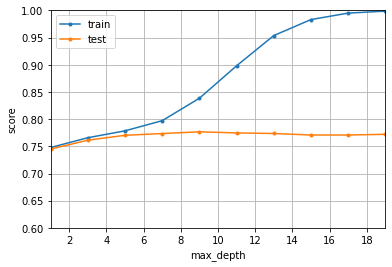

In [172]:

def evaluate_md(X, y, MD):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, RandomForestClassifier(n_estimators=150, 
                                   max_depth=MD, 
                                   max_features=0.14,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_md(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_md, 'max_depth', np.arange(1, 15, 2), scale='linear', ylim=(0.6,1))
plot_curve_md(X_train,y_train,0.25)

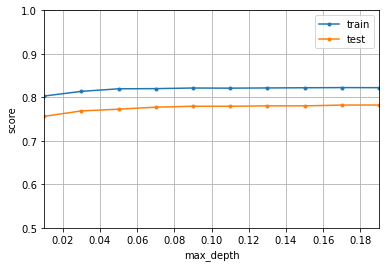

In [42]:

def evaluate_mf(X, y, mf):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, RandomForestClassifier(n_estimators=150, 
                                   max_depth=8, 
                                   max_features=mf,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_mf(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_mf, 'max_depth', np.arange(0.01,0.2, 0.02), scale='linear', ylim=(0.5,1))
plot_curve_mf(X_train,y_train,0.25)


### XGBoost

Enough of that. Lets tune another (XGBoost) model. I have high hopes for this one.

In [41]:
transformer = make_column_transformer((StandardScaler(), numeric_features), 
                               (OneHotEncoder(), categorical_features))

pipe = make_pipeline(transformer, GradientBoostingClassifier())

In [42]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'gradientboostingclassifier__n_estimators': [100],  # Number of boosting stages
    'gradientboostingclassifier__learning_rate': [0.1],  # Step size shrinkage used in update to prevent overfitting
    'gradientboostingclassifier__max_depth': [3],  # Maximum depth of the individual trees
    #'gradientboostingclassifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    #'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'gradientboostingclassifier__max_features': [0.15],  # Number of features to consider when looking for the best split
    'gradientboostingclassifier__subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the individual base learners
    'gradientboostingclassifier__random_state': [123]  # Set a fixed random state for reproducibility
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__max_features': 0.15, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__random_state': 123, 'gradientboostingclassifier__subsample': 0.9}
Best score: 0.7955712181779928
Execution time: 176.12364888191223 seconds


^^^ Gonna have to run this overnight ^^^

I know its annoying to keep copy pasting this plot_curve code chunk, but right now im lazy and dont have as much time as i would like for this side project. Maybe next year ill write a function where I can adjust the parameters

#### Previnting overfitting

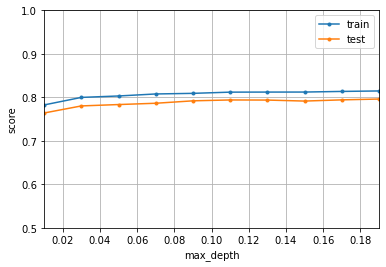

In [32]:

def evaluate_mf(X, y, mf):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, GradientBoostingClassifier(n_estimators=150, 
                                   max_depth=3, 
                                   max_features=mf,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_mf(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_mf, 'max_depth', np.arange(0.01,0.2, 0.02), scale='linear', ylim=(0.5,1))
plot_curve_mf(X_train,y_train,0.25)


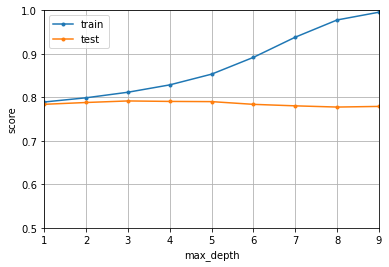

In [33]:


def evaluate_md(X, y, md):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, GradientBoostingClassifier(n_estimators=150, 
                                   max_depth=md, 
                                   max_features=0.12,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_md(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_md, 'max_depth', np.arange(1,10, 1), scale='linear', ylim=(0.5,1))
plot_curve_md(X_train,y_train,0.25)


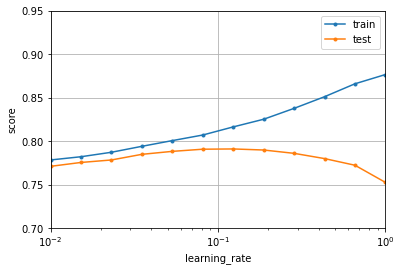

In [36]:

def evaluate_lr(X, y, lr):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, GradientBoostingClassifier(n_estimators=150, 
                                   max_depth=3, 
                                   max_features=0.12,
                                   learning_rate = lr,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_lr(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_lr, 'learning_rate', np.logspace(-2, -0, num=12), scale='log', ylim=(0.7,0.95))
plot_curve_lr(X_train,y_train,0.25)


In [37]:
np.logspace(-2, -0, num=12)

array([0.01      , 0.01519911, 0.0231013 , 0.03511192, 0.05336699,
       0.08111308, 0.12328467, 0.18738174, 0.28480359, 0.43287613,
       0.65793322, 1.        ])

#### New Pipeline, With feature selection

In [60]:
from sklearn.feature_selection import SelectFromModel


In [62]:
transformer = make_column_transformer((StandardScaler(), numeric_features), 
                               (OneHotEncoder(), categorical_features))

selector = SelectFromModel(RandomForestClassifier(max_depth = 3, max_features = 0.15), threshold='mean')


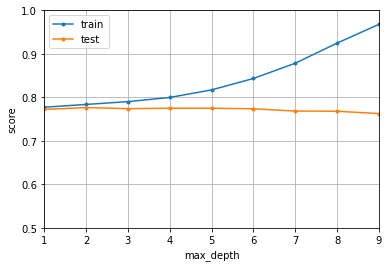

In [63]:

def evaluate_md(X, y, md):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, selector,  GradientBoostingClassifier(n_estimators=150, 
                                   max_depth=md, 
                                   max_features=0.12,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_md(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_md, 'max_depth', np.arange(1,10, 1), scale='linear', ylim=(0.5,1))
plot_curve_md(X_train,y_train,0.25)


Doesnt seem to help much. I think the GradientBoosted model will be my mens model. No feature selection needed

### Final ensemble models

In [202]:
# Random Forest

pipetunerf = make_pipeline(transformer, RandomForestClassifier(n_estimators=200, 
                                   max_depth=8, 
                                   max_features=0.14,
                                   random_state=123))

pipetunerf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Season', 'DayNum',
                                                   'T1_Wins', 'T1_Losses',
                                                   'T1_SOS', 'T1_P_PG',
                                                   'T1_PA_PG', 'T1_FGM_PG',
                                                   'T1_FGM3_PG', 'T1_OR_PG',
                                                   'T1_DR_PG', 'T1_Ast_PG',
                                                   'T1_TO_PG', 'T1_Stl_PG',
                                                   'T1_Blk_PG', 'T1_PF_PG',
                                                   'T1_Opp_FGM_PG',
                                                   'T1_Opp_FGM3_PG',
                                                   'T1_Opp_OR_PG',
                       

In [203]:
# Make predictions on the test set
y_pred = pipetunerf.predict(X_test)

from sklearn.metrics import accuracy_score

# Assuming y_true and y_pred are the true labels and predicted labels, respectively
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7873999419352163


In [204]:
# XGBoost

pipetunedboost = make_pipeline(transformer, GradientBoostingClassifier(n_estimators=200,  
                                                                    max_depth=3,      
                                                                    learning_rate=0.094,  
                                                                    subsample=0.9))

pipetunedboost.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error

# Make predictions on the test set
y_pred = pipetunedboost.predict(X_test)

from sklearn.metrics import accuracy_score

# Assuming y_true and y_pred are the true labels and predicted labels, respectively
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8037825059101655


### Neural Network is worth a try


In [53]:
transformer.fit(X_train, y_train)

X_train_trans = transformer.transform(X_train)

X_test_trans = transformer.transform(X_test)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(64, activation='leaky_relu', input_shape=(X_train_trans.shape[1],)),
    Dropout(0.5),  # Optional dropout layer to prevent overfitting
    Dense(32, activation='leaky_relu'),
    Dropout(0.5),  # Optional dropout layer
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_trans, y_train, epochs=10, batch_size=32, validation_data=(X_test_trans, y_test))

Epoch 1/10
2971/2971 [==============================] - 9s 3ms/step - loss: 0.4669 - accuracy: 0.7697 - val_loss: 0.4098 - val_accuracy: 0.7989
Epoch 2/10
2971/2971 [==============================] - 8s 3ms/step - loss: 0.4238 - accuracy: 0.7940 - val_loss: 0.4054 - val_accuracy: 0.8008
Epoch 3/10
2971/2971 [==============================] - 8s 3ms/step - loss: 0.4200 - accuracy: 0.7956 - val_loss: 0.4043 - val_accuracy: 0.8006
Epoch 4/10
2971/2971 [==============================] - 8s 3ms/step - loss: 0.4183 - accuracy: 0.7951 - val_loss: 0.4038 - val_accuracy: 0.8025
Epoch 5/10
2971/2971 [==============================] - 8s 3ms/step - loss: 0.4168 - accuracy: 0.7966 - val_loss: 0.4037 - val_accuracy: 0.8013
Epoch 6/10
2971/2971 [==============================] - 8s 3ms/step - loss: 0.4150 - accuracy: 0.7975 - val_loss: 0.4037 - val_accuracy: 0.8016
Epoch 7/10
2971/2971 [==============================] - 8s 3ms/step - loss: 0.4143 - accuracy: 0.7976 - val_loss: 0.4038 - val_accuracy:

In [58]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_trans, y_test)
print(f'Test accuracy: {test_acc}')

743/743 [==============================] - 1s 2ms/step - loss: 0.4022 - accuracy: 0.8016
Test accuracy: 0.8016073107719421


# Women

## Data Prep

In [446]:
WGames = pd.concat([WRegSeason, WTourney])

WGames.isna().sum()

Season     0
WLoc       0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
dtype: int64

In [447]:
WGames = WGames.loc[WGames.Season >= 2003]
WGames = WGames.reset_index().drop(columns = 'index')
WGames

,Season,WLoc,DayNum,WTeamID,WScore,LTeamID,LScore
0,2010,H,11,3103,63,3237,49
1,2010,N,11,3104,73,3399,68
2,2010,A,11,3110,71,3224,59
3,2010,A,11,3111,63,3267,58
4,2010,H,11,3119,74,3447,70
...,...,...,...,...,...,...,...
77460,2023,H,147,3376,86,3268,75
77461,2023,N,147,3439,84,3326,74
77462,2023,N,151,3234,77,3376,73
77463,2023,N,151,3261,79,3439,72


In [448]:
WGamesSwitch = WGames[['Season', 'WLoc', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore']]
WGamesSwitch

,Season,WLoc,DayNum,LTeamID,LScore,WTeamID,WScore
0,2010,H,11,3237,49,3103,63
1,2010,N,11,3399,68,3104,73
2,2010,A,11,3224,59,3110,71
3,2010,A,11,3267,58,3111,63
4,2010,H,11,3447,70,3119,74
...,...,...,...,...,...,...,...
77460,2023,H,147,3268,75,3376,86
77461,2023,N,147,3326,74,3439,84
77462,2023,N,151,3376,73,3234,77
77463,2023,N,151,3439,72,3261,79


In [449]:
# I dont want team 1 to be the winner every time

WGamesSwitch.loc[WGamesSwitch['WLoc'] == 'H', 'WLoc'] = 'A'
WGamesSwitch.loc[WGamesSwitch['WLoc'] == 'A', 'WLoc'] = 'H'
WGames.columns.values[1] = 'location'
WGamesSwitch.columns.values[1] = 'location'

WGames.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(WGames.columns)]
WGamesSwitch.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(WGamesSwitch.columns)]

In [ ]:
half = WGames.shape[0]//2

print(half)
np.random.seed(123)

half_indices = random.sample(list(WGames.index), k=half)

WGamesHalf = WGames.iloc[half_indices].sort_values(['Season', 'DayNum'])
WGamesHalf['Team1Win'] = 1
print(WGamesHalf.head(20))

WGamesSwitchHalf = WGamesSwitch.drop(half_indices).sort_values(['Season', 'DayNum'])
WGamesSwitchHalf['Team1Win'] = 0
print(WGamesSwitchHalf.head(20))

38732
       Season location  DayNum  T1_TeamID  T1_Score  T2_TeamID  T2_Score  \
76204    2003        N     138       3314        72       3122        70   
76202    2003        N     138       3280        73       3264        47   
76198    2003        H     138       3160        84       3140        45   
76210    2003        N     138       3438        72       3228        56   
76209    2003        N     138       3435        54       3251        44   
76207    2003        H     138       3390        82       3444        66   
76200    2003        N     138       3261        86       3402        50   
76223    2003        N     139       3376        68       3151        54   
76216    2003        A     139       3203        71       3328        61   
76219    2003        N     139       3323        59       3112        47   
76218    2003        H     139       3256        94       3337        60   
76222    2003        N     139       3364        71       3462        62   
76228 

In [451]:
WGamesSwitchHalf.shape

(38733, 8)

In [452]:
WomensGames = pd.concat([WGamesHalf, WGamesSwitchHalf]).sort_index()
Womens = WomensGames.loc[WomensGames.Season >= 2003]
Womens.shape

(77465, 8)

In [453]:
TeamInfo = pd.read_csv('Data\\TeamInfo.csv')

In [454]:
TeamInfo

,TeamID,Season,Wins,Losses,Conference,SOS,ConfWins,ConfLosses,ConfSOS,P_PG,...,POSS_PER_GAME,Opp_POSS_PER_GAME,DREB_PCT,OREB_PCT,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT
0,1101,2014,2.0,19.0,southland,0.485419,0.0,0.0,0.436877,63.142857,...,66.466667,66.546667,0.662016,0.249258,0.471985,0.564171,94.999284,118.141226,0.804116,0.225677
1,1101,2015,7.0,21.0,southland,0.475056,0.0,0.0,0.427551,61.000000,...,64.084286,64.280000,0.661853,0.241632,0.473347,0.553020,95.187142,111.787714,0.851499,0.200071
2,1101,2016,9.0,18.0,southland,0.446531,0.0,0.0,0.401878,69.851852,...,68.714074,69.502222,0.723810,0.245011,0.505151,0.545549,101.655815,109.722045,0.926485,0.195119
3,1101,2017,9.0,16.0,southland,0.460726,0.0,0.0,0.414654,67.880000,...,68.406400,68.312000,0.682578,0.231902,0.524756,0.528689,99.230481,106.335636,0.933182,0.211676
4,1101,2018,12.0,15.0,southland,0.464745,0.0,0.0,0.418270,70.666667,...,70.065185,70.167407,0.700559,0.265217,0.509180,0.517394,100.858460,103.772987,0.971914,0.205629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12852,3421,2013,0.0,28.0,big_south,0.495835,0.0,0.0,0.446252,49.000000,...,67.437143,67.255714,0.609467,0.334288,0.370103,0.482467,72.660255,100.363219,0.723973,0.316697
12853,3438,2021,0.0,5.0,acc,0.547935,0.0,0.0,0.493142,51.600000,...,69.272000,70.376000,0.590909,0.283871,0.406130,0.465870,74.488971,92.361032,0.806498,0.285830
12854,3451,2013,0.0,29.0,big_sky,0.523098,0.0,0.0,0.470788,52.862069,...,73.714483,73.573793,0.601497,0.301548,0.355318,0.492701,71.711917,100.532423,0.713321,0.280205
12855,3464,2010,0.0,30.0,horizon,0.494315,0.0,0.0,0.444883,48.566667,...,70.344000,71.217333,0.615005,0.296825,0.338480,0.521393,69.041662,104.422144,0.661178,0.274366


In [455]:
# Merge for T1_TeamID
merged_t1 = pd.merge(Womens, TeamInfo, left_on=['T1_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')

# Merge for T2_TeamID

merged_t2 = pd.merge(Womens, TeamInfo, left_on=['T2_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')

merged_t1

,Season,location,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,Team1Win,TeamID,Wins,...,POSS_PER_GAME,Opp_POSS_PER_GAME,DREB_PCT,OREB_PCT,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT
0,2010,H,11,3103,63,3237,49,1,3103.0,17.0,...,67.957333,68.320000,0.633513,0.396648,0.437877,0.425409,91.577068,87.285324,1.049169,0.268796
1,2010,N,11,3104,73,3399,68,1,3104.0,11.0,...,74.182069,74.182069,0.635672,0.353535,0.433093,0.439794,86.460154,90.318322,0.957283,0.258451
2,2010,A,11,3110,71,3224,59,1,3110.0,13.0,...,63.586667,63.647619,0.653691,0.371742,0.443463,0.416742,95.033400,85.440670,1.112274,0.238894
3,2010,A,11,3111,63,3267,58,1,3111.0,19.0,...,73.503226,72.912258,0.670347,0.391986,0.469360,0.415259,90.362503,87.555524,1.032059,0.288774
4,2010,H,11,3447,70,3119,74,0,3447.0,9.0,...,71.784000,71.576000,0.643054,0.356725,0.416573,0.465341,84.048442,93.699937,0.896996,0.275363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77460,2023,H,147,3376,86,3268,75,1,3376.0,32.0,...,71.595000,72.108750,0.814651,0.480751,0.504067,0.347404,113.747468,70.856519,1.605321,0.173720
77461,2023,N,147,3326,74,3439,84,0,3326.0,25.0,...,77.411250,77.217500,0.728880,0.264599,0.522276,0.475495,104.313004,88.386700,1.180189,0.174393
77462,2023,N,151,3234,77,3376,73,1,3234.0,26.0,...,77.465000,77.521250,0.777403,0.256189,0.580605,0.455604,112.994578,92.031217,1.227785,0.179517
77463,2023,N,151,3439,72,3261,79,0,3439.0,27.0,...,68.623226,68.714839,0.775615,0.307863,0.519371,0.418996,105.672865,83.045405,1.272471,0.184269


In [456]:
# Rename columns for T1 and T2
merged_t1.columns = [f"T1_{col}" if col != 'T1_TeamID' else col for col in merged_t1.columns]
merged_t2.columns = [f"T2_{col}" if col != 'T2_TeamID' else col for col in merged_t2.columns]

merged_t1

,T1_Season,T1_location,T1_DayNum,T1_TeamID,T1_T1_Score,T1_T2_TeamID,T1_T2_Score,T1_Team1Win,T1_TeamID,T1_Wins,...,T1_POSS_PER_GAME,T1_Opp_POSS_PER_GAME,T1_DREB_PCT,T1_OREB_PCT,T1_EFG_PCT,T1_Opp_EFG_PCT,T1_OFF_RTG,T1_DEF_RTG,T1_NET_RTG,T1_TOV_PCT
0,2010,H,11,3103,63,3237,49,1,3103.0,17.0,...,67.957333,68.320000,0.633513,0.396648,0.437877,0.425409,91.577068,87.285324,1.049169,0.268796
1,2010,N,11,3104,73,3399,68,1,3104.0,11.0,...,74.182069,74.182069,0.635672,0.353535,0.433093,0.439794,86.460154,90.318322,0.957283,0.258451
2,2010,A,11,3110,71,3224,59,1,3110.0,13.0,...,63.586667,63.647619,0.653691,0.371742,0.443463,0.416742,95.033400,85.440670,1.112274,0.238894
3,2010,A,11,3111,63,3267,58,1,3111.0,19.0,...,73.503226,72.912258,0.670347,0.391986,0.469360,0.415259,90.362503,87.555524,1.032059,0.288774
4,2010,H,11,3447,70,3119,74,0,3447.0,9.0,...,71.784000,71.576000,0.643054,0.356725,0.416573,0.465341,84.048442,93.699937,0.896996,0.275363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77460,2023,H,147,3376,86,3268,75,1,3376.0,32.0,...,71.595000,72.108750,0.814651,0.480751,0.504067,0.347404,113.747468,70.856519,1.605321,0.173720
77461,2023,N,147,3326,74,3439,84,0,3326.0,25.0,...,77.411250,77.217500,0.728880,0.264599,0.522276,0.475495,104.313004,88.386700,1.180189,0.174393
77462,2023,N,151,3234,77,3376,73,1,3234.0,26.0,...,77.465000,77.521250,0.777403,0.256189,0.580605,0.455604,112.994578,92.031217,1.227785,0.179517
77463,2023,N,151,3439,72,3261,79,0,3439.0,27.0,...,68.623226,68.714839,0.775615,0.307863,0.519371,0.418996,105.672865,83.045405,1.272471,0.184269


In [457]:

# Drop duplicate columns (TeamID)
merged_t1.drop(columns='T1_TeamID', inplace=True)
merged_t2.drop(columns='T2_TeamID', inplace=True)

# Merge the two merged DataFrames horizontally
result_df = pd.concat([merged_t1, merged_t2], axis=1)

result_df['ScoreDiff'] = result_df['T1_T1_Score'] - result_df['T1_T2_Score']
result_df.drop(columns=['T2_Season', 'T2_location', 'T2_DayNum', 'T2_T1_TeamID', 'T1_T2_TeamID', 'T2_Team1Win', 'T1_T1_Score', 'T1_T2_Score','T2_T2_Score','T2_T1_Score'], inplace = True)
result_df.rename(columns = {'T1_Season':'Season', 'T1_location':'location', 'T1_DayNum':'DayNum', 'T1_Team1Win': 'Team1Win'}, inplace = True)

# Display the resulting DataFrame
print(result_df.columns)


Index(['Season', 'location', 'DayNum', 'Team1Win', 'T1_Wins', 'T1_Losses',
       'T1_Conference', 'T1_SOS', 'T1_ConfWins', 'T1_ConfLosses', 'T1_ConfSOS',
       'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG',
       'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG',
       'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG',
       'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG',
       'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT',
       'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T2_Wins', 'T2_Losses', 'T2_Conference', 'T2_SOS',
       'T2_ConfWins', 'T2_ConfLosses', 'T2_ConfSOS', 'T2_P_PG', 'T2_PA_PG',
       'T2_FGM_PG', 'T2_FGM3_PG', 'T2_OR_PG', 'T2_DR_PG', 'T2_Ast_PG',
       'T2_TO_PG', 'T2_Stl_PG', 'T2_Blk_PG'

Couple more columns to ficx up. Ill do that later.

In [458]:
result_df['Team1Win'].mean()

0.4999935454721487

<BarContainer object of 149 artists>

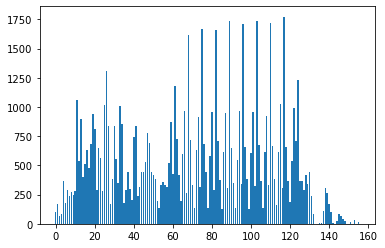

In [459]:
game_counts = result_df.groupby('DayNum')['Team1Win'].count()
plt.bar(game_counts.index, game_counts)


## Modelling
### Regression Model

Target is score difference
#### Train Test Split


In [111]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = result_df.drop(columns=['ScoreDiff','Team1Win'])  # Features are all columns except 'Team1Win'
y = result_df['ScoreDiff']  # Target variable is 'ScoreDiff'

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [113]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder#, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from category_encoders import TargetEncoder

In [114]:
X_train.columns

Index(['Season', 'location', 'DayNum', 'T1_Wins', 'T1_Losses', 'T1_Conference',
       'T1_SOS', 'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG',
       'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG',
       'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG',
       'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG',
       'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT',
       'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T2_Wins', 'T2_Losses', 'T2_Conference', 'T2_SOS',
       'T2_P_PG', 'T2_PA_PG', 'T2_FGM_PG', 'T2_FGM3_PG', 'T2_OR_PG',
       'T2_DR_PG', 'T2_Ast_PG', 'T2_TO_PG', 'T2_Stl_PG', 'T2_Blk_PG',
       'T2_PF_PG', 'T2_Opp_FGM_PG', 'T2_Opp_FGM3_PG', 'T2_Opp_OR_PG',
       'T2_Opp_DR_PG', 'T2_Opp_Ast_PG', 'T2_Op

In [115]:
numeric_features = ['Season', 'DayNum', 'T1_Wins', 'T1_Losses',
       'T1_SOS', 'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG',
       'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG',
       'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG',
       'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG',
       'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT',
       'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T2_Wins', 'T2_Losses', 'T2_SOS',
       'T2_P_PG', 'T2_PA_PG', 'T2_FGM_PG', 'T2_FGM3_PG', 'T2_OR_PG',
       'T2_DR_PG', 'T2_Ast_PG', 'T2_TO_PG', 'T2_Stl_PG', 'T2_Blk_PG',
       'T2_PF_PG', 'T2_Opp_FGM_PG', 'T2_Opp_FGM3_PG', 'T2_Opp_OR_PG',
       'T2_Opp_DR_PG', 'T2_Opp_Ast_PG', 'T2_Opp_TO_PG', 'T2_Opp_Stl_PG',
       'T2_Opp_Blk_PG', 'T2_Opp_PF_PG', 'T2_FG_PCT', 'T2_FG_PCT3', 'T2_FT_PCT',
       'T2_Opp_FG_PCT', 'T2_Opp_FG_PCT3', 'T2_Opp_FT_PCT', 'T2_POSS_PER_GAME',
       'T2_Opp_POSS_PER_GAME', 'T2_DREB_PCT', 'T2_OREB_PCT', 'T2_EFG_PCT',
       'T2_Opp_EFG_PCT', 'T2_OFF_RTG', 'T2_DEF_RTG', 'T2_NET_RTG',
       'T2_TOV_PCT']

categorical_features = ['T1_Conference', 'T1_Conference', 'location']

In [118]:
transformer = make_column_transformer((StandardScaler(), numeric_features), 
                               (OneHotEncoder(), categorical_features))

pipe = make_pipeline(transformer, XGBRegressor())

In [119]:


start_time = time.time()

# Define the parameter grid including learning rate
param_grid = {
    'xgbregressor__n_estimators': [100, 150],
    'xgbregressor__max_depth': [2, 3, 5],
    'xgbregressor__learning_rate': [0.01, 0.1],  # Include learning rate here
    'xgbregressor__gamma': [0, 0.2]
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 100}
Best score: -8.669698352783383
Execution time: 1146.4770245552063 seconds


### Classification Model
Target is Winning team
#### Train Test Split

In [468]:
result_df.dropna(inplace = True)

In [469]:
# Define features (X) and target variable (y)
X = result_df.drop(columns=['ScoreDiff','Team1Win'])  # Features are all columns except 'Team1Win'
y = result_df['Team1Win']  # Target variable is 'ScoreDiff'

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [470]:
X_test.isna().sum()

Season            0
location          0
DayNum            0
T1_Wins           0
T1_Losses         0
                 ..
T2_Opp_EFG_PCT    0
T2_OFF_RTG        0
T2_DEF_RTG        0
T2_NET_RTG        0
T2_TOV_PCT        0
Length: 89, dtype: int64

#### HyperParameter Tuning

In [461]:
pipe = make_pipeline(transformer, GradientBoostingClassifier())

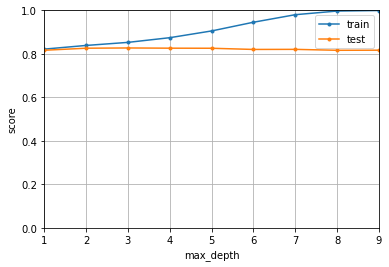

In [471]:

# MODEL IMPLEMENTATION:
from sklearn.model_selection import cross_validate


def evaluate_md(X, y, md):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, GradientBoostingClassifier(n_estimators=150, 
                                   max_depth=md, 
                                   max_features=0.12,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_md(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_md, 'max_depth', np.arange(1,10, 1), scale='linear', ylim=(0,1))
plot_curve_md(X_train,y_train,0.25)


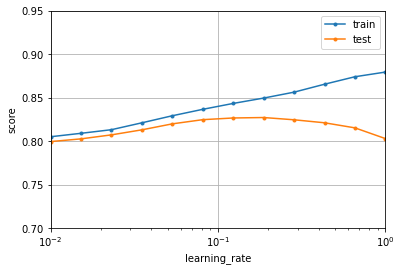

In [473]:
# MODEL IMPLEMENTATION:
from sklearn.model_selection import cross_validate


def evaluate_lr(X, y, lr):
    """ Evaluate a Logistic Regression model with cross-validation on the provided image data.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct output values
    MF -- Max_features

    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    # Setting solver='lbfgs' and cv=5 even though it's the default, since defaults can change
    score = cross_validate(make_pipeline(transformer, GradientBoostingClassifier(n_estimators=150, 
                                   max_depth=2, 
                                   max_features=0.12,
                                   learning_rate = lr,
                                   random_state=123)), X, y, return_train_score= True, cv=5, scoring = 'accuracy', n_jobs=-1)
    res = {'train': np.mean(score['train_score']),
           'test': np.mean(score['test_score'])}
    print(res)
    return res

def plot_curve_lr(X,y,train_size):
    """ Plots the train and test accuracy of logistic regression on a
    subsample of the given data for different amounts of features.
    X -- the data for training and testing
    y -- the correct labels
    train_size -- the proportion of the data used for training and testing, between 0.0 and 1.0. 

    Returns: a plot as described above, with max_features on the x-axis and accuracy on
    the y-axis.
    """
    Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=train_size, random_state=123)
    plot_live(Xs, ys, evaluate_lr, 'learning_rate', np.logspace(-2, -0, num=12), scale='log', ylim=(0.7,0.95))
plot_curve_lr(X_train,y_train,0.25)


In [474]:
start_time = time.time()
# Define the parameter grid
param_grid = {
    'gradientboostingclassifier__n_estimators': [100],  # Number of boosting stages
    'gradientboostingclassifier__learning_rate': [0.08, 0.12],  # Step size shrinkage used in update to prevent overfitting
    'gradientboostingclassifier__max_depth': [2, 3],  # Maximum depth of the individual trees
    'gradientboostingclassifier__max_features': [0.15],  # Number of features to consider when looking for the best split
    'gradientboostingclassifier__subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the individual base learners
    'gradientboostingclassifier__random_state': [123]  # Set a fixed random state for reproducibility
}

try:
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV on your data
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = end_time - start_time

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("Execution time:", execution_time, "seconds")

except Exception as e:
    print("An error occurred:", e)

Best parameters: {'gradientboostingclassifier__learning_rate': 0.12, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__max_features': 0.15, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__random_state': 123, 'gradientboostingclassifier__subsample': 1.0}
Best score: 0.8274396153855372
Execution time: 220.12190413475037 seconds


### Final Womens Model

In [477]:
#Final Womens Model
learningRate = 0.1
maxDepth = 2
subsample = 0.9
pipeWomen = make_pipeline(transformer, GradientBoostingClassifier(n_estimators = 200, 
                                                                  max_depth = maxDepth, max_features = 0.14, learning_rate = learningRate,
                                                                  subsample = subsample))

pipeWomen.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error

# Make predictions on the test set
y_pred = pipeWomen.predict(X_test)

from sklearn.metrics import accuracy_score

# Assuming y_true and y_pred are the true labels and predicted labels, respectively
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
                          
                          

Accuracy: 0.83089905874716


# Mens Predictions

In [205]:
TourneyTeams = pd.read_csv('Data\\2024_tourney_seeds.csv')

reminding myself what columns i need, (Without team1 win of course)

In [206]:
result_df.columns

Index(['Season', 'location', 'DayNum', 'Team1Win', 'T1_Wins', 'T1_Losses',
       'T1_Conference', 'T1_SOS', 'T1_ConfWins', 'T1_ConfLosses', 'T1_ConfSOS',
       'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG',
       'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG',
       'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG',
       'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG',
       'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT',
       'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T1_Ranking1', 'T1_Ranking2', 'T1_Ranking3', 'T2_Wins',
       'T2_Losses', 'T2_Conference', 'T2_SOS', 'T2_ConfWins', 'T2_ConfLosses',
       'T2_ConfSOS', 'T2_P_PG', 'T2_PA_PG', 'T2_FGM_PG', 'T2_FGM3_PG',
       'T2_OR_PG', 'T2_DR_PG', 'T2_

In [254]:
MensTeams = TourneyTeams.loc[TourneyTeams.TeamID < 2001]['TeamID']
type(MensTeams)

# Add first four teams (Colorado, UVA, Motana State, Wagner
MT = MensTeams.append(pd.Series([1160, 1286, 1438, 1447]))

In [255]:
from itertools import product

# Generate the cartesian product of team_ids
cartesian_product = product(MT, MT)

# Convert the cartesian product into a DataFrame
cartesian_df = pd.DataFrame(cartesian_product, columns=['T1_TeamID', 'T2_TeamID'])

# Filter out rows where T1_TeamID is equal to T2_TeamID
cartesian_df = cartesian_df[cartesian_df['T1_TeamID'] != cartesian_df['T2_TeamID']]

# Reset index
cartesian_df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
type(cartesian_df)

pandas.core.frame.DataFrame

In [256]:
cartesian_df.shape
prediction_df = cartesian_df

In [257]:
random.choice([140,141,142,142,144,145])

142

In [258]:
#Add in game description columns
cartesian_df['Season'] = 2024
cartesian_df['location'] = 'N'
cartesian_df['DayNum'] = 0
for row in range(len(cartesian_df)):
    cartesian_df['DayNum'][row] = random.choice([138,139,140,141,142,142,144,145])

cartesian_df

C:\Users\18582\AppData\Local\Temp/ipykernel_13780/1140380347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cartesian_df['DayNum'][row] = random.choice([138,139,140,141,142,142,144,145])


,T1_TeamID,T2_TeamID,Season,location,DayNum
0,1163,1235,2024,N,140
1,1163,1228,2024,N,140
2,1163,1120,2024,N,142
3,1163,1361,2024,N,139
4,1163,1140,2024,N,145
...,...,...,...,...,...
4551,1447,1443,2024,N,142
4552,1447,1255,2024,N,142
4553,1447,1160,2024,N,142
4554,1447,1286,2024,N,142


In [259]:
# Merge for T1_TeamID
merged_t1 = pd.merge(cartesian_df, MTeamInfo, left_on=['T1_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_t1.drop(columns='TeamID', inplace=True)

# Merge for T2_TeamID
merged_t2 = pd.merge(cartesian_df, MTeamInfo, left_on=['T2_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
merged_t2.drop(columns='TeamID', inplace=True)

merged_t1

,T1_TeamID,T2_TeamID,Season,location,DayNum,Wins,Losses,Conference,SOS,ConfWins,...,OREB_PCT,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT,Ranking1,Ranking2,Ranking3
0,1163,1235,2024,N,140,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
1,1163,1228,2024,N,140,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
2,1163,1120,2024,N,142,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
3,1163,1361,2024,N,139,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
4,1163,1140,2024,N,145,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,1447,1443,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0
4552,1447,1255,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0
4553,1447,1160,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0
4554,1447,1286,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0


In [260]:
# Rename columns for T1 and T2
merged_t1.columns = [f"T1_{col}" if col != 'T1_TeamID' else col for col in merged_t1.columns]
merged_t2.columns = [f"T2_{col}" if col != 'T2_TeamID' else col for col in merged_t2.columns]

merged_t1

,T1_TeamID,T1_T2_TeamID,T1_Season,T1_location,T1_DayNum,T1_Wins,T1_Losses,T1_Conference,T1_SOS,T1_ConfWins,...,T1_OREB_PCT,T1_EFG_PCT,T1_Opp_EFG_PCT,T1_OFF_RTG,T1_DEF_RTG,T1_NET_RTG,T1_TOV_PCT,T1_Ranking1,T1_Ranking2,T1_Ranking3
0,1163,1235,2024,N,140,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
1,1163,1228,2024,N,140,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
2,1163,1120,2024,N,142,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
3,1163,1361,2024,N,139,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
4,1163,1140,2024,N,145,31.0,3.0,big_east,0.530880,3.0,...,0.353608,0.570963,0.450960,122.938451,95.740216,1.284084,0.137585,6,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,1447,1443,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0
4552,1447,1255,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0
4553,1447,1160,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0
4554,1447,1286,2024,N,142,14.0,15.0,nec,0.443539,3.0,...,0.276986,0.445921,0.483685,97.391285,99.429964,0.979496,0.140997,299,298,293.0


In [261]:
# Drop duplicate columns (TeamID)
merged_t1.drop(columns='T1_TeamID', inplace=True)
merged_t2.drop(columns='T2_TeamID', inplace=True)

# Merge the two merged DataFrames horizontally
games24 = pd.concat([merged_t1, merged_t2], axis=1)
games24.columns

Index(['T1_T2_TeamID', 'T1_Season', 'T1_location', 'T1_DayNum', 'T1_Wins',
       'T1_Losses', 'T1_Conference', 'T1_SOS', 'T1_ConfWins', 'T1_ConfLosses',
       'T1_ConfSOS', 'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG',
       'T1_OR_PG', 'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG',
       'T1_Blk_PG', 'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG',
       'T1_Opp_OR_PG', 'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG',
       'T1_Opp_Stl_PG', 'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT',
       'T1_FG_PCT3', 'T1_FT_PCT', 'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3',
       'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME', 'T1_Opp_POSS_PER_GAME',
       'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT', 'T1_Opp_EFG_PCT',
       'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG', 'T1_TOV_PCT', 'T1_Ranking1',
       'T1_Ranking2', 'T1_Ranking3', 'T2_T1_TeamID', 'T2_Season',
       'T2_location', 'T2_DayNum', 'T2_Wins', 'T2_Losses', 'T2_Conference',
       'T2_SOS', 'T2_ConfWins', 'T2_ConfLosses', 'T2_ConfSOS', 'T2_P_PG

In [262]:
games24.drop(columns=['T2_Season', 'T2_location', 'T2_DayNum', 'T2_T1_TeamID', 'T1_T2_TeamID'], inplace = True)
games24.rename(columns = {'T1_Season':'Season', 'T1_location':'location', 'T1_DayNum':'DayNum'}, inplace = True)

# Display the resulting DataFrame
games24

,Season,location,DayNum,T1_Wins,T1_Losses,T1_Conference,T1_SOS,T1_ConfWins,T1_ConfLosses,T1_ConfSOS,...,T2_OREB_PCT,T2_EFG_PCT,T2_Opp_EFG_PCT,T2_OFF_RTG,T2_DEF_RTG,T2_NET_RTG,T2_TOV_PCT,T2_Ranking1,T2_Ranking2,T2_Ranking3
0,2024,N,140,31.0,3.0,big_east,0.530880,3.0,0.0,0.597933,...,0.301923,0.519076,0.470824,109.722554,90.545707,1.211792,0.148204,18,14,5.0
1,2024,N,140,31.0,3.0,big_east,0.530880,3.0,0.0,0.597933,...,0.346774,0.538079,0.479761,118.177027,103.055943,1.146727,0.144118,7,10,10.0
2,2024,N,142,31.0,3.0,big_east,0.530880,3.0,0.0,0.597933,...,0.313855,0.541344,0.434211,116.699621,96.381425,1.210810,0.142116,5,5,4.0
3,2024,N,139,31.0,3.0,big_east,0.530880,3.0,0.0,0.597933,...,0.307389,0.498128,0.472389,108.133222,98.719170,1.095362,0.149856,21,20,21.0
4,2024,N,145,31.0,3.0,big_east,0.530880,3.0,0.0,0.597933,...,0.311277,0.550524,0.480483,115.466826,98.421502,1.173187,0.146204,9,9,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,2024,N,142,14.0,15.0,nec,0.443539,3.0,0.0,0.516860,...,0.260513,0.519076,0.482842,104.228891,97.799940,1.065736,0.175691,153,155,132.0
4552,2024,N,142,14.0,15.0,nec,0.443539,3.0,0.0,0.516860,...,0.367000,0.493943,0.513329,107.095360,101.696830,1.053085,0.173731,142,189,157.0
4553,2024,N,142,14.0,15.0,nec,0.443539,3.0,0.0,0.516860,...,0.294241,0.552995,0.492903,113.032249,101.104631,1.117973,0.171896,33,22,26.0
4554,2024,N,142,14.0,15.0,nec,0.443539,3.0,0.0,0.516860,...,0.189711,0.538813,0.522740,105.855188,105.591201,1.002500,0.159965,282,248,213.0


In [263]:
cartesian_df['prediction'] = pipetunedboost.predict(games24)

In [268]:
probs = pipetunedboost.predict_proba(games24)
cartesian_df['probs'] = probs[:,1]

In [352]:
predictions = cartesian_df.drop(columns = ['Season', 'location', 'DayNum'])

In [353]:
# Format ID: 2024_Team1ID_Team2ID, Pred : probs
neat_df = predictions
neat_df['ID'] = ''
for row in range(len(neat_df)):
    neat_df['ID'][row] = f"2024_{neat_df['T1_TeamID'][row]}_{neat_df['T2_TeamID'][row]}"
    
    

C:\Users\18582\AppData\Local\Temp/ipykernel_13780/2339741167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neat_df['ID'][row] = f"2024_{neat_df['T1_TeamID'][row]}_{neat_df['T2_TeamID'][row]}"


In [356]:
# Average Probs for each 'ordering' of teams
neat_df['Pred'] = neat_df['probs']
for row in range(len(neat_df)):
    g1 = neat_df['probs'][row]
    g2 = neat_df.loc[(neat_df['T1_TeamID'] == neat_df['T2_TeamID'][row]) & (neat_df['T2_TeamID'] == neat_df['T1_TeamID'][row])]['probs'] 
    neat_df['Pred'][row] = (g1+(1-g2))/2
               

C:\Users\18582\AppData\Local\Temp/ipykernel_13780/149705444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neat_df['Pred'][row] = (g1+(1-g2))/2


In [358]:
                   
neat = neat_df[['ID', 'Pred']]
neat

,ID,Pred
0,2024_1163_1235,0.577233
1,2024_1163_1228,0.696274
2,2024_1163_1120,0.643672
3,2024_1163_1361,0.691666
4,2024_1163_1140,0.748162
...,...,...
4551,2024_1447_1443,0.218281
4552,2024_1447_1255,0.209544
4553,2024_1447_1160,0.033225
4554,2024_1447_1286,0.341469


In [587]:
## Uncomment to Save neat df

#neat.to_csv('Data\\PredsMH2HNeat.csv')

In [364]:
#Format TEam1, Team2, probs

curiosity_df = neat_df[['T1_TeamID', 'T2_TeamID', 'Pred']]
curiosity_df

,T1_TeamID,T2_TeamID,Pred
0,1163,1235,0.577233
1,1163,1228,0.696274
2,1163,1120,0.643672
3,1163,1361,0.691666
4,1163,1140,0.748162
...,...,...,...
4551,1447,1443,0.218281
4552,1447,1255,0.209544
4553,1447,1160,0.033225
4554,1447,1286,0.341469


In [365]:
MTeams = pd.read_csv('Data\\MTeams.csv')[['TeamID', 'TeamName']]
MTeams

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M
...,...,...
373,1474,Queens NC
374,1475,Southern Indiana
375,1476,Stonehill
376,1477,TX A&M Commerce


In [366]:
# Merge with MTeams for TeamID to TeamName conversion for T1_TeamID
curiosity_df = curiosity_df.merge(MTeams, left_on='T1_TeamID', right_on='TeamID', how='left')
curiosity_df.rename(columns={'TeamName': 'Team1'}, inplace=True)
curiosity_df.drop(columns=['TeamID'], inplace=True)  # Drop the redundant TeamID column

# Merge again for TeamID to TeamName conversion for T2_TeamID
curiosity_df = curiosity_df.merge(MTeams, left_on='T2_TeamID', right_on='TeamID', how='left')
curiosity_df.rename(columns={'TeamName': 'Team2'}, inplace=True)
curiosity_df.drop(columns=['TeamID'], inplace=True)  # Drop the redundant TeamID column


In [586]:
## Uncomment to save df

#curiosity_df.to_csv('Data\\PredsMH2HFull.csv')

In [367]:
def get_pred(Team1, Team2):
    return curiosity_df.loc[(curiosity_df.Team1.str.lower().isin([Team1.lower(), Team2.lower()])) & (curiosity_df.Team2.str.lower().isin([Team1.lower(), Team2.lower()]))]

In [444]:
get_pred("dayton", 'nevada')

,T1_TeamID,T2_TeamID,Pred,Team1,Team2
1498,1173,1305,0.608933,Dayton,Nevada
1697,1305,1173,0.391067,Nevada,Dayton


In [373]:
def searchByTeam(team):
    return curiosity_df.loc[curiosity_df.Team1.str.lower() == team.lower()].sort_values('Team2')

In [440]:
searchByTeam('connecticut').sort_values('Pred').head(50)

,T1_TeamID,T2_TeamID,Pred,Team1,Team2
47,1163,1222,0.332050,Connecticut,Houston
31,1163,1345,0.350651,Connecticut,Purdue
0,1163,1235,0.577233,Connecticut,Iowa St
32,1163,1397,0.627951,Connecticut,Tennessee
2,1163,1120,0.643672,Connecticut,Auburn
16,1163,1112,0.645019,Connecticut,Arizona
34,1163,1242,0.669206,Connecticut,Kansas
3,1163,1361,0.691666,Connecticut,San Diego St
15,1163,1314,0.693963,Connecticut,North Carolina
1,1163,1228,0.696274,Connecticut,Illinois


# Womens Predictions

reminding myself what columns i need, (Without team1 win of course)

In [494]:
result_df.columns

Index(['Season', 'location', 'DayNum', 'Team1Win', 'T1_Wins', 'T1_Losses',
       'T1_Conference', 'T1_SOS', 'T1_ConfWins', 'T1_ConfLosses', 'T1_ConfSOS',
       'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG', 'T1_OR_PG',
       'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG', 'T1_Blk_PG',
       'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG', 'T1_Opp_OR_PG',
       'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG', 'T1_Opp_Stl_PG',
       'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT', 'T1_FG_PCT3', 'T1_FT_PCT',
       'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3', 'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME',
       'T1_Opp_POSS_PER_GAME', 'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT',
       'T1_Opp_EFG_PCT', 'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG',
       'T1_TOV_PCT', 'T2_Wins', 'T2_Losses', 'T2_Conference', 'T2_SOS',
       'T2_ConfWins', 'T2_ConfLosses', 'T2_ConfSOS', 'T2_P_PG', 'T2_PA_PG',
       'T2_FGM_PG', 'T2_FGM3_PG', 'T2_OR_PG', 'T2_DR_PG', 'T2_Ast_PG',
       'T2_TO_PG', 'T2_Stl_PG', 'T2_Blk_PG'

In [495]:
WomensTeams = TourneyTeams.loc[TourneyTeams.TeamID >2000]['TeamID']
WomensTeams.drop(columns = 'ScoreDiff', inplace = True)

WomensTeams

C:\Users\18582\anaconda3\lib\site-packages\pandas\core\generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


64     3376
65     3323
66     3333
67     3231
68     3328
       ... 
123    3162
124    3267
125    3238
126    3263
127    3394
Name: TeamID, Length: 64, dtype: int64

In [496]:
# Add first four teams (Sacred Heart, Vanderbilt, UT MArtin, auburn
WT = WomensTeams.append(pd.Series([3357, 3435, 3404, 3120]))
WT

64     3376
65     3323
66     3333
67     3231
68     3328
       ... 
127    3394
0      3357
1      3435
2      3404
3      3120
Length: 68, dtype: int64

In [497]:
from itertools import product

# Generate the cartesian product of team_ids
w_cartesian_product = product(WT, WT)

# Convert the cartesian product into a DataFrame
w_cartesian_df = pd.DataFrame(w_cartesian_product, columns=['T1_TeamID', 'T2_TeamID'])

# Filter out rows where T1_TeamID is equal to T2_TeamID
w_cartesian_df = w_cartesian_df[w_cartesian_df['T1_TeamID'] != w_cartesian_df['T2_TeamID']]

# Reset index
w_cartesian_df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
type(w_cartesian_df)

pandas.core.frame.DataFrame

In [498]:
w_cartesian_df.shape


(4556, 2)

In [499]:
random.choice([140,141,142,142,144,145])

141

In [500]:
#Add in game description columns
w_cartesian_df['Season'] = 2024
w_cartesian_df['location'] = 'N'
w_cartesian_df['DayNum'] = 0
for row in range(len(w_cartesian_df)):
    w_cartesian_df['DayNum'][row] = random.choice([138,139,140,141,142,142,144,145])

w_cartesian_df

C:\Users\18582\AppData\Local\Temp/ipykernel_13780/997212450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_cartesian_df['DayNum'][row] = random.choice([138,139,140,141,142,142,144,145])


,T1_TeamID,T2_TeamID,Season,location,DayNum
0,3376,3323,2024,N,138
1,3376,3333,2024,N,139
2,3376,3231,2024,N,140
3,3376,3328,2024,N,144
4,3376,3304,2024,N,142
...,...,...,...,...,...
4551,3120,3263,2024,N,142
4552,3120,3394,2024,N,144
4553,3120,3357,2024,N,141
4554,3120,3435,2024,N,142


In [502]:
# Merge for T1_TeamID
w_merged_t1 = pd.merge(w_cartesian_df, TeamInfo, left_on=['T1_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
w_merged_t1.drop(columns='TeamID', inplace=True)

# Merge for T2_TeamID
w_merged_t2 = pd.merge(w_cartesian_df, TeamInfo, left_on=['T2_TeamID', 'Season'], right_on=['TeamID', 'Season'], how='left')
w_merged_t2.drop(columns='TeamID', inplace=True)

w_merged_t1

,T1_TeamID,T2_TeamID,Season,location,DayNum,Wins,Losses,Conference,SOS,ConfWins,...,POSS_PER_GAME,Opp_POSS_PER_GAME,DREB_PCT,OREB_PCT,EFG_PCT,Opp_EFG_PCT,OFF_RTG,DEF_RTG,NET_RTG,TOV_PCT
0,3376,3323,2024,N,138,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
1,3376,3333,2024,N,139,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
2,3376,3231,2024,N,140,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
3,3376,3328,2024,N,144,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
4,3376,3304,2024,N,142,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,3120,3263,2024,N,142,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839
4552,3120,3394,2024,N,144,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839
4553,3120,3357,2024,N,141,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839
4554,3120,3435,2024,N,142,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839


In [503]:
# Rename columns for T1 and T2
w_merged_t1.columns = [f"T1_{col}" if col != 'T1_TeamID' else col for col in w_merged_t1.columns]
w_merged_t2.columns = [f"T2_{col}" if col != 'T2_TeamID' else col for col in w_merged_t2.columns]

w_merged_t1

,T1_TeamID,T1_T2_TeamID,T1_Season,T1_location,T1_DayNum,T1_Wins,T1_Losses,T1_Conference,T1_SOS,T1_ConfWins,...,T1_POSS_PER_GAME,T1_Opp_POSS_PER_GAME,T1_DREB_PCT,T1_OREB_PCT,T1_EFG_PCT,T1_Opp_EFG_PCT,T1_OFF_RTG,T1_DEF_RTG,T1_NET_RTG,T1_TOV_PCT
0,3376,3323,2024,N,138,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
1,3376,3333,2024,N,139,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
2,3376,3231,2024,N,140,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
3,3376,3328,2024,N,144,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
4,3376,3304,2024,N,142,32.0,0.0,sec,0.581831,0.0,...,76.005000,76.392500,0.762630,0.391519,0.545603,0.361286,113.232682,73.714697,1.536094,0.173097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,3120,3263,2024,N,142,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839
4552,3120,3394,2024,N,144,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839
4553,3120,3357,2024,N,141,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839
4554,3120,3435,2024,N,142,20.0,11.0,sec,0.563852,0.0,...,73.930323,73.305806,0.716632,0.302682,0.436311,0.413226,90.102276,79.780680,1.129375,0.199839


In [504]:
# Drop duplicate columns (TeamID)
w_merged_t1.drop(columns='T1_TeamID', inplace=True)
w_merged_t2.drop(columns='T2_TeamID', inplace=True)

# Merge the two merged DataFrames horizontally
w_games24 = pd.concat([w_merged_t1, w_merged_t2], axis=1)
w_games24.columns

Index(['T1_T2_TeamID', 'T1_Season', 'T1_location', 'T1_DayNum', 'T1_Wins',
       'T1_Losses', 'T1_Conference', 'T1_SOS', 'T1_ConfWins', 'T1_ConfLosses',
       'T1_ConfSOS', 'T1_P_PG', 'T1_PA_PG', 'T1_FGM_PG', 'T1_FGM3_PG',
       'T1_OR_PG', 'T1_DR_PG', 'T1_Ast_PG', 'T1_TO_PG', 'T1_Stl_PG',
       'T1_Blk_PG', 'T1_PF_PG', 'T1_Opp_FGM_PG', 'T1_Opp_FGM3_PG',
       'T1_Opp_OR_PG', 'T1_Opp_DR_PG', 'T1_Opp_Ast_PG', 'T1_Opp_TO_PG',
       'T1_Opp_Stl_PG', 'T1_Opp_Blk_PG', 'T1_Opp_PF_PG', 'T1_FG_PCT',
       'T1_FG_PCT3', 'T1_FT_PCT', 'T1_Opp_FG_PCT', 'T1_Opp_FG_PCT3',
       'T1_Opp_FT_PCT', 'T1_POSS_PER_GAME', 'T1_Opp_POSS_PER_GAME',
       'T1_DREB_PCT', 'T1_OREB_PCT', 'T1_EFG_PCT', 'T1_Opp_EFG_PCT',
       'T1_OFF_RTG', 'T1_DEF_RTG', 'T1_NET_RTG', 'T1_TOV_PCT', 'T2_T1_TeamID',
       'T2_Season', 'T2_location', 'T2_DayNum', 'T2_Wins', 'T2_Losses',
       'T2_Conference', 'T2_SOS', 'T2_ConfWins', 'T2_ConfLosses', 'T2_ConfSOS',
       'T2_P_PG', 'T2_PA_PG', 'T2_FGM_PG', 'T2_FGM3_PG', 'T2

In [505]:
w_games24.drop(columns=['T2_Season', 'T2_location', 'T2_DayNum', 'T2_T1_TeamID', 'T1_T2_TeamID'], inplace = True)
w_games24.rename(columns = {'T1_Season':'Season', 'T1_location':'location', 'T1_DayNum':'DayNum'}, inplace = True)

# Display the resulting DataFrame
w_games24

,Season,location,DayNum,T1_Wins,T1_Losses,T1_Conference,T1_SOS,T1_ConfWins,T1_ConfLosses,T1_ConfSOS,...,T2_POSS_PER_GAME,T2_Opp_POSS_PER_GAME,T2_DREB_PCT,T2_OREB_PCT,T2_EFG_PCT,T2_Opp_EFG_PCT,T2_OFF_RTG,T2_DEF_RTG,T2_NET_RTG,T2_TOV_PCT
0,2024,N,138,32.0,0.0,sec,0.581831,0.0,0.0,0.523648,...,77.382500,76.591250,0.738657,0.313725,0.499039,0.419264,102.332569,79.357955,1.289506,0.182939
1,2024,N,139,32.0,0.0,sec,0.581831,0.0,0.0,0.523648,...,69.028387,69.814194,0.781802,0.267797,0.529592,0.398485,103.790867,85.711381,1.210934,0.180851
2,2024,N,140,32.0,0.0,sec,0.581831,0.0,0.0,0.523648,...,71.911724,71.873103,0.776495,0.229058,0.582143,0.450000,110.528234,89.093805,1.240583,0.177900
3,2024,N,144,32.0,0.0,sec,0.581831,0.0,0.0,0.523648,...,78.987097,78.655484,0.748906,0.330579,0.486158,0.438632,97.280078,87.560287,1.111007,0.203382
4,2024,N,142,32.0,0.0,sec,0.581831,0.0,0.0,0.523648,...,71.956364,71.681212,0.787234,0.336150,0.494321,0.461300,101.955731,89.876051,1.134404,0.191614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,2024,N,142,20.0,11.0,sec,0.563852,0.0,0.0,0.507467,...,66.204848,65.432727,0.770186,0.320268,0.463321,0.451901,97.081602,86.047201,1.128237,0.173474
4552,2024,N,144,20.0,11.0,sec,0.563852,0.0,0.0,0.507467,...,72.531852,72.903704,0.709110,0.310231,0.443005,0.402925,89.871117,81.690713,1.100139,0.227742
4553,2024,N,141,20.0,11.0,sec,0.563852,0.0,0.0,0.507467,...,69.687742,68.581935,0.695187,0.304890,0.452677,0.442549,95.078507,84.005945,1.131807,0.178677
4554,2024,N,142,20.0,11.0,sec,0.563852,0.0,0.0,0.507467,...,71.270968,70.821935,0.713558,0.337476,0.462125,0.452691,96.179958,86.951373,1.106135,0.197791


In [512]:

w_cartesian_df['prediction'] = pipeWomen.predict(games24)

In [513]:
probs = pipeWomen.predict_proba(games24)
w_cartesian_df['probs'] = probs[:,1]

In [514]:
predictions = w_cartesian_df.drop(columns = ['Season', 'location', 'DayNum'])

In [515]:
# Format ID: 2024_Team1ID_Team2ID, Pred : probs
w_neat_df = predictions
w_neat_df['ID'] = ''
for row in range(len(neat_df)):
    w_neat_df['ID'][row] = f"2024_{w_neat_df['T1_TeamID'][row]}_{w_neat_df['T2_TeamID'][row]}"
    
    

C:\Users\18582\AppData\Local\Temp/ipykernel_13780/861807791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_neat_df['ID'][row] = f"2024_{w_neat_df['T1_TeamID'][row]}_{w_neat_df['T2_TeamID'][row]}"


In [516]:
# Average Probs for each 'ordering' of teams
w_neat_df['Pred'] = w_neat_df['probs']
for row in range(len(w_neat_df)):
    g1 = w_neat_df['probs'][row]
    g2 = w_neat_df.loc[(w_neat_df['T1_TeamID'] == w_neat_df['T2_TeamID'][row]) & (w_neat_df['T2_TeamID'] == w_neat_df['T1_TeamID'][row])]['probs'] 
    w_neat_df['Pred'][row] = (g1+(1-g2))/2
               

C:\Users\18582\AppData\Local\Temp/ipykernel_13780/3553423569.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_neat_df['Pred'][row] = (g1+(1-g2))/2


In [517]:
                   
w_neat = w_neat_df[['ID', 'Pred']]
w_neat

,ID,Pred
0,2024_3376_3323,0.844039
1,2024_3376_3333,0.843404
2,2024_3376_3231,0.807060
3,2024_3376_3328,0.911981
4,2024_3376_3304,0.936140
...,...,...
4551,2024_3120_3263,0.672982
4552,2024_3120_3394,0.814397
4553,2024_3120_3357,0.781013
4554,2024_3120_3435,0.459504


In [583]:
#Uncomment to save

#w_neat.to_csv('Data\\PredsWH2HNeat.csv')

In [518]:
#Format TEam1, Team2, probs

w_curiosity_df = w_neat_df[['T1_TeamID', 'T2_TeamID', 'Pred']]
w_curiosity_df

,T1_TeamID,T2_TeamID,Pred
0,3376,3323,0.844039
1,3376,3333,0.843404
2,3376,3231,0.807060
3,3376,3328,0.911981
4,3376,3304,0.936140
...,...,...,...
4551,3120,3263,0.672982
4552,3120,3394,0.814397
4553,3120,3357,0.781013
4554,3120,3435,0.459504


In [519]:
WTeams = pd.read_csv('Data\\WTeams.csv')[['TeamID', 'TeamName']]
WTeams

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force
2,3103,Akron
3,3104,Alabama
4,3105,Alabama A&M
...,...,...
371,3474,Queens NC
372,3475,Southern Indiana
373,3476,Stonehill
374,3477,TX A&M Commerce


In [520]:
# Merge with MTeams for TeamID to TeamName conversion for T1_TeamID
w_curiosity_df = w_curiosity_df.merge(WTeams, left_on='T1_TeamID', right_on='TeamID', how='left')
w_curiosity_df.rename(columns={'TeamName': 'Team1'}, inplace=True)
w_curiosity_df.drop(columns=['TeamID'], inplace=True)  # Drop the redundant TeamID column

# Merge again for TeamID to TeamName conversion for T2_TeamID
w_curiosity_df = w_curiosity_df.merge(WTeams, left_on='T2_TeamID', right_on='TeamID', how='left')
w_curiosity_df.rename(columns={'TeamName': 'Team2'}, inplace=True)
w_curiosity_df.drop(columns=['TeamID'], inplace=True)  # Drop the redundant TeamID column


In [584]:
#Uncomment to save

#w_curiosity_df.to_csv('Data\\PredsWH2HFull.csv')

In [521]:
def w_get_pred(Team1, Team2):
    return w_curiosity_df.loc[(w_curiosity_df.Team1.str.lower().isin([Team1.lower(), Team2.lower()])) & (w_curiosity_df.Team2.str.lower().isin([Team1.lower(), Team2.lower()]))]

In [582]:
w_get_pred("west virginia", 'princeton')

,T1_TeamID,T2_TeamID,Pred,Team1,Team2
2652,3452,3343,0.453367,West Virginia,Princeton
2719,3343,3452,0.546633,Princeton,West Virginia


In [524]:
def w_searchByTeam(team):
    return w_curiosity_df.loc[w_curiosity_df.Team1.str.lower() == team.lower()].sort_values('Team2')

In [573]:
w_searchByTeam('virginia tech').sort_values('Pred').head(50)

,T1_TeamID,T2_TeamID,Pred,Team1,Team2
3417,3439,3376,0.143994,Virginia Tech,South Carolina
3433,3439,3400,0.229793,Virginia Tech,Texas
3449,3439,3234,0.290080,Virginia Tech,Iowa
3467,3439,3163,0.291450,Virginia Tech,Connecticut
3434,3439,3390,0.298467,Virginia Tech,Stanford
3436,3439,3211,0.329761,Virginia Tech,Gonzaga
3451,3439,3261,0.364681,Virginia Tech,LSU
3420,3439,3231,0.383657,Virginia Tech,Indiana
3450,3439,3417,0.396810,Virginia Tech,UCLA
3466,3439,3326,0.419187,Virginia Tech,Ohio St
